# Import packages

In [81]:
import pandas as pd 
import chart_studio.plotly as py 
import plotly.graph_objs as go 
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# Import books review data

In [5]:
books = pd.read_csv('../data/books.csv')
books.head(1)

(13719, 11)
 


,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,dontcare
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249,NaN


# High level glance at Data

## Data dictionary

*isbn13A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.

*language_code -Helps understand what is the primary language of the book. For instance, eng is standard for English.

*num_pages-Number of pages the book contains.

*ratings_count -Total number of ratings the book received.

*text_reviews_count -Total number of written text reviews the book received.


We have around 13719  book reviews, from  7605 different authors.

In [99]:
books.dtypes

title                  object
authors                object
average_rating        float64
isbn                   object
language_code          object
num_pages             float64
ratings_count           int64
text_reviews_count      int64
dtype: object

### Are the books unique ?

we have books unique isbn numbers  but  they have similar titles.
I am little wary of this data set now. It might  be a good  for proof of concept but  we may need to get cleaner data.

In [93]:
books_with_same_isbn =(books['isbn'].value_counts() >1) ==True
len(books_with_same_isbn.index [books_with_same_isbn >1])

0

In [94]:
books_with_same_title = (books['title'].value_counts()  )
len(books_with_same_title.index[books_with_same_title >1])

766

In [113]:
dup_books =books_with_same_title.index[books_with_same_title >1]

#for book in dup_books:
    #print( books[books['title'] == book]['authors'])
    #print("-----------------------------------")

In [96]:
# write Code to delete duplicate books 

# compare title 
#compare author
# compare rating 


In [97]:
# renaming the. column so that naming style is consisten with other column names
books.rename(columns ={'# num_pages' : 'num_pages'}, inplace=True)
books['num_pages']=  pd.to_numeric(books['num_pages'], errors='coerce')
books['num_pages'].value_counts().sort_values(ascending =False)
print(f" confirming we have no  Nans {books['average_rating'].isnull().sum()}")
print(f" confirming we have books with zeros pages {len(books[books['num_pages'] ==0])}")

 confirming we have no  Nans 0
 confirming we have books with zeros pages 85


In [98]:
#Dropping the last corrupted columns which has only handful of values
books = books.drop(['dontcare','isbn13','bookID'], axis =1)

# Dropping the 5 rowes which has average rating as non-integer value
books= books[~books['average_rating'].isnull()]
books['average_rating'] =  pd.to_numeric(books['average_rating'],errors='coerce')

###  What language the books are in ?

In [54]:
books['language_code'].value_counts()

eng              10594
en-US             1699
spa                419
en-GB              341
ger                238
fre                209
jpn                 64
por                 27
mul                 21
ita                 19
zho                 16
grc                 12
en-CA                9
nl                   7
rus                  7
swe                  6
glg                  4
enm                  3
lat                  3
cat                  3
tur                  3
ara                  2
9781857237252        1
msa                  1
heb                  1
gla                  1
nor                  1
ale                  1
9780851742717        1
srp                  1
wel                  1
dan                  1
9781563841552        1
9781593600112        1
9780674842113        1
Name: language_code, dtype: int64

### Average length of books?

In [125]:
def plot_distribution(column, title,xlabel,xstart,x_end,stepsize, bins =50):
    plt.figure(figsize=(16,10))
    plt.hist(books[column], bins)
    plt.gca().set(title='Most Books are 150-400 pages', ylabel='Count of books');
    plt.xlim(xstart,x_end)
    plt.xticks(np.arange(xstart, x_end, step=stepsize));
    plt.axvline(books['num_pages'].mean(), color='r',label ="average length")

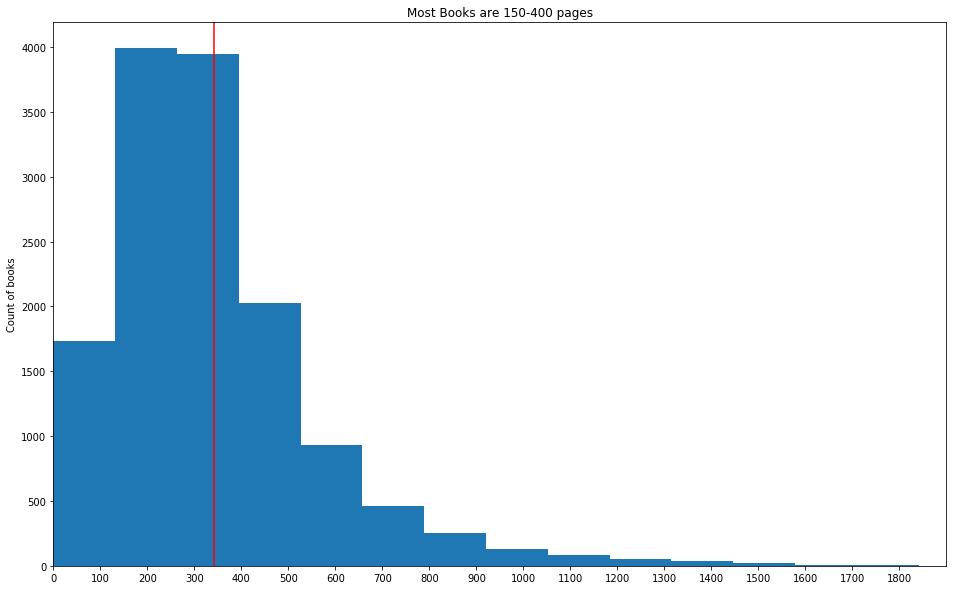

In [126]:
plot_distribution('num_pages',"length in pages",'Average lenth of a book is around 350 pages',0,1900,100)

### Do we have enough book ratings?

In [177]:
def reviewer_category(ratings_count):
    if ratings_count <10 :
        return('<10')
    elif ratings_count < 100:
        return('11-100')
    elif ratings_count <= 1000:
        return('101-1000')
    else:
         return('>1000')
 

In [178]:
books['ratings_weight'] =books['ratings_count'].map(reviewer_category)
books['ratings_weight'].value_counts()

>1000       6059
101-1000    3941
11-100      2736
<10          983
Name: ratings_weight, dtype: int64

Text(0.5, 1.0, 'Do we have enough people rate the books ?')

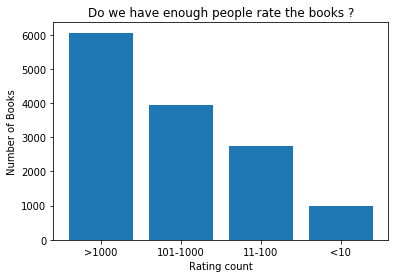

In [182]:
plt.bar(books['ratings_weight'].value_counts().index,books['ratings_weight'].value_counts())
plt.xlabel("Rating count")
plt.ylabel("Number of Books")
plt.title("Do we have enough people rate the books ?")

3         116
2         115
0         114
1         114
4         113
         ... 
120981      1
2199        1
26779       1
2207        1
22865       1
Name: ratings_count, Length: 6030, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13134fc50>,
      dtype=object)

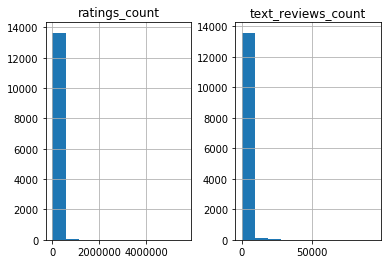

In [188]:
# The. data does not have text reviews  so 'text_reviews_count' may not be useful ,
#plus distribution matches the rating count  so we are going to use rating count 
# as a quantitattive measure for " how much did the user like a particular book"

books.hist(['ratings_count','text_reviews_count'])

### Average rating for the books

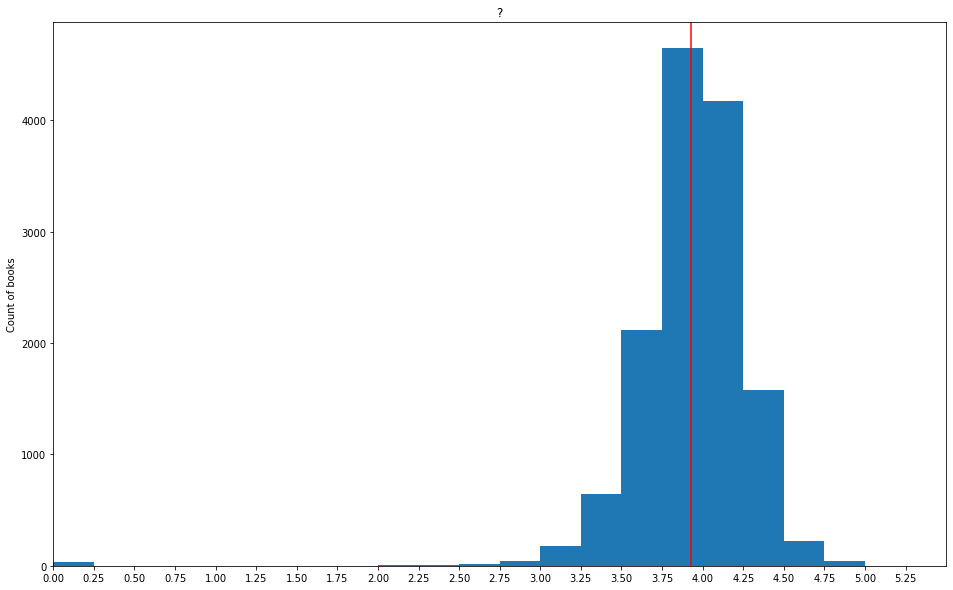

In [205]:
plt.figure(figsize=(16,10))
plt.hist(books['average_rating'], 20)
plt.gca().set(title='?', ylabel='Count of books');
plt.xlim(0,5.5)
plt.xticks(np.arange(0, 5.5, step=0.25));
plt.axvline(books['average_rating'].mean(), color='r',label ="average length")

# References

In [ ]:
https://www.kaggle.com/jealousleopard/goodreadsbooks
https://www.kaggle.com/qwp8510/analyze-goodread-book-beginner-eda

# install the Table of contents extension
https://github.com/minrk/ipython_extensions